# Hands on: Persistent Homology

In this notebook, you will find some exercises to familiarize yourself with the basics of persistence diagrams and the Ripser library.  
(See more at https://github.com/ctralie/TDALabs)

In [1]:
# Perform all of the necessary library imports.  
import numpy as np
import matplotlib.pyplot as plt
from ripser import Rips
import time

## **Example 1:** Circles

As a first example, we will make a circle.  Once you understand this example, starting from the code below, see if you can modify the point cloud in order to:

#### Exercises/Questions
* Increase the birth time of the $H_1$ generator without changing the radius of the circle
* Decrease the birth time of the $H_1$ generator without changing the radius of the circle
* What happens to $H_1$ when you add a point that is at the center of the circle at position $(0, 0)$?
* Change the point cloud so that there are two $H_1$ generators with large (>1) but different persistences.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


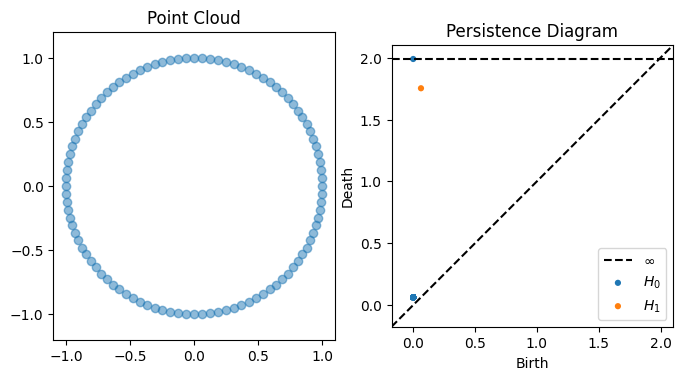

In [38]:
# Create 100 points on the unit circle
N = 100
t = np.linspace(0, 2*np.pi, N+1)[0:N]
X = np.zeros((N, 2))
X[:, 0] = np.cos(t)
X[:, 1] = np.sin(t)


# Compute the persistence diagram of this point cloud
rips = Rips()
dgms = rips.fit_transform(X)


# Plot the figures
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], alpha = 0.5)
plt.axis('equal')
plt.title("Point Cloud")

plt.subplot(122)
rips.plot(dgms)
plt.title("Persistence Diagram")

plt.show()

## **Example 2:** Sphere and Projective Plane

We will now randomly sample some points on the two dimensional sphere and compute persistent homology up to dimension 2, using the <i>geodesic distance</i>, which is the arc length between points.  A point $X = (x, y, z)$ is randomly drawn from a 3D gaussian distribution 

$$(x, y, z) \sim \left(\frac{1}{2 \pi}\right)^{3/2} \exp{\left( - (x^2+y^2+z^2)/2 \right) }$$

and normalized to have a length of 1 

(<i>Why does this evenly sample on the sphere?</i> See Marsaglia, G. _"Choosing a Point from the Surface of a Sphere."_ Ann. Math. Stat. 43, 645-646, 1972.
or Muller, M. E. _"A Note on a Method for Generating Points Uniformly on N-Dimensional Spheres."_ Comm. Assoc. Comput. Mach. 2, 19-20, Apr. 1959).

Note that the arc length along a unit circle is equal to the angle subtending that circle in radians. Thus, given two unit vectors on the sphere $x_1$ and $x_2$, the arc length between them is $\cos^{-1}(x_1 \cdot x_2)$.  We will implement this in code below to compute all pairwwise arc lengths between our sampled points on the sphere.  We will then compute a Rips filtration up to dimension 2.


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


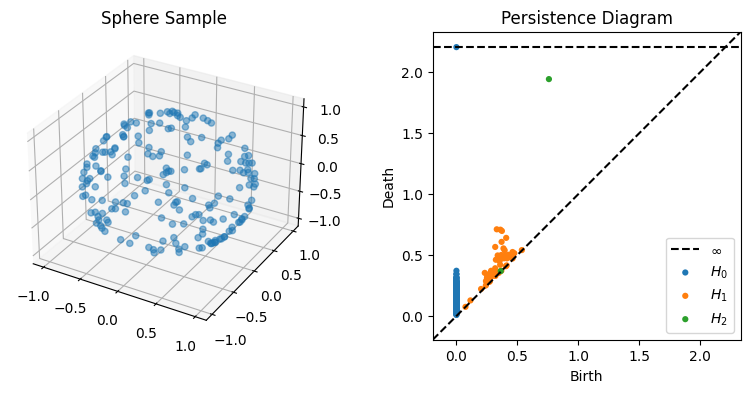

In [39]:
# Step 1: Setup the point cloud
N = 200 #Number of points
X = np.random.randn(N, 3) #Draw from 3D Gaussian
X = X/np.sqrt(np.sum(X**2, 1))[:, None] #Normalize each point to unit length

# Step 2: Compute all pairwise arc lengths between sampled points
dotProds = X.dot(X.T) #Entry ij in this matrix holds the dot product between point i and j, or cos(theta)
#The dot products should be in [-1, 1], but may leave this range due to numerical roundoff
dotProds[dotProds < -1] = -1
dotProds[dotProds > 1] = 1
DSphere = np.arccos(dotProds) #The arc length is the inverse cosine of the dot products of unit vectors
np.fill_diagonal(DSphere, 0) #Be sure distance of points to themselves is zero

# Step 3: Compute the persistence diagram of this metric space, described by its distance matrix
rips = Rips(maxdim=2)
dgms = rips.fit_transform(DSphere, distance_matrix=True)

# Step 4: Plot the figures
fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha = 0.5)
plt.title("Sphere Sample")
plt.subplot(122)
rips.plot(dgms)
plt.title("Persistence Diagram");


#### Questions
* How many generators with long lifetime are in $H_1$ and $H_2$?  Does this match the homology of a sphere?
* Compare the persistence diagram of the sphere endowed with either the Euclidean distance and the geodesic distance. Is there any change?

## **Example 3:** 3D Embedded Torus and Flat Torus

We will now sample points from a torus embedded in 3D and compute persistent homology up to $H_2$.  Given a parameter $R$ which is the radius of a circle through the center of the tube and a parameter $r$ which is the width of the tube, we use the following equation for the 3D coordinates of a point $(\theta, \phi)$, where $\theta$ is along the $r$ radius circle and $\phi$ is along the $R$ radius circle:

$x = (R + r \cos(\theta)) \cos (\phi)$

$y = (R + r \cos(\theta)) \sin (\phi)$

$z = r \sin (\theta)$

#### Questions

* What happens to the persistence diagram as you vary $R$ and $r$?
* What happens to the persistence diagram as you vary $n\_sample$?

In [41]:
from ripser import ripser

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


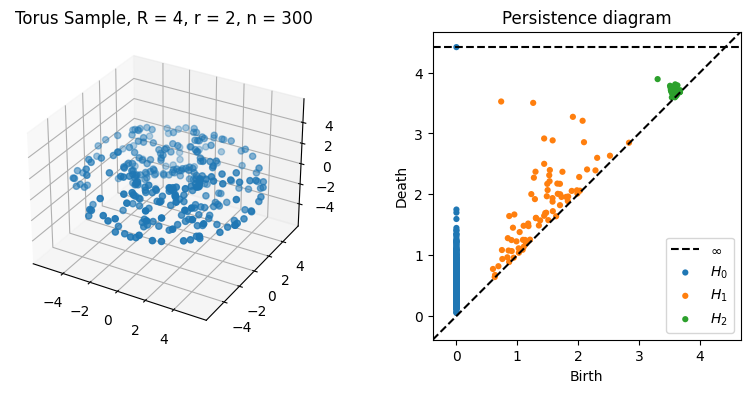

In [54]:
N = 10000 #Number of initial points in (theta, phi) space
n_sample = 300 #Number of points to evenly subsample in 3D

R = 4
r = 2
theta = np.random.rand(N)*2*np.pi
phi = np.random.rand(N)*2*np.pi

X = np.zeros((N, 3))
X[:, 0] = (R + r*np.cos(theta))*np.cos(phi)
X[:, 1] = (R + r*np.cos(theta))*np.sin(phi)
X[:, 2] = r*np.sin(theta)
xr = [np.min(X.flatten()), np.max(X.flatten())]

sample = np.random.choice(N, size=n_sample, replace=False)
X_sample = X[sample]

#Now compute persistence diagrams up to H2 on a furthest points subsample
rips = Rips(maxdim=2)
dgms = rips.fit_transform(X_sample)

plt.figure(figsize=(10, 4))
ax = plt.subplot(121, projection='3d')
ax.scatter(X_sample[:, 0], X_sample[:, 1], X_sample[:, 2])
ax.set_xlim(xr)
ax.set_ylim(xr)
ax.set_zlim(xr)
plt.title("Torus Sample, R = %g, r = %g, n = %g"%(R, r, n_sample))
plt.subplot(122)
rips.plot(dgms)
plt.title("Persistence diagram")
plt.show()

Now we will sample points from a "flat torus."  The domain is $[0, 1] \times [0, 1]$, with $(x, 0)$ identified with $(x, 1)$ and $(0, y)$ identified with $(1, y)$.  The metric is induced by the flat planar Euclidean metric

#### Exercise
* Fill in the code below in the function <b>get_flat_torus_dists</b>, which computes all pairwise distances of points on a flat torus.  Right now, the code simply computes the Euclidean distance between points without any identifications.

<b>Hint: You may need to use the function <u>np.minimum</u></b>

In [55]:
def get_flat_torus_dists(x1, y1, x2, y2):
    """
    Compute all pairwise distances between all points (x1, y1) and points (x2, y2)
    on the flat torus [0, 1] x [0, 1]
    
    Parameters:
    x1 : ndarray (M)
        An M-length list of x coordinates of each point in the first point set
    y1 : ndarray (M)
        An M-length list of y coordinates of each point in the first point set
    x2 : ndarray (N)
        An N-length list of x coordinates of each point in the second point set
    y2 : ndarray (N)
        An N-length list of y coordinates of each point in the second point set

    Returns:
    D : ndarray (M, N)
        A distance matrix whose ijth entry is the distance along the flat torus between (x1[i], y1[i]) and (x2[j], y2[j])
    """
    
    dx1 = np.abs(x1[:, None] - x2[None, :])
    dy1 = np.abs(y1[:, None] - y2[None, :])
    
    ##TODO: FINISH THIS AND MAKE IDENTIFICATIONS
    dx2 = np.abs(x1[:, None] -(np.ones(len(x2))- x2[None, :]))
    dy2 = np.abs(y1[:, None] -(np.ones(len(y2))- y2[None, :]))
    
    dx = np.minimum(dx1, dx2)
    dy = np.minimum(dy1, dy2)
    ##
    
    
    return np.sqrt(dx**2 + dy**2)
    

Now use your function to compute a distance matrix, run ripser, and verify that you get the correct signature for a torus

In [57]:
from persim import plot_diagrams

In [ ]:
res = 15 #Number of points along each dimension
#Sample slightly differently so that the two persistence diagrams won't be the same
gridx = np.linspace(0, 1, res+1)[0:res]
gridy = gridx*0.99
x, y = np.meshgrid(gridx, gridy)
x = x.flatten()
y = y.flatten()

# Compute the distance matrix, which is the distance between all points and themselves
D = get_flat_torus_dists(x, y, x, y)
np.fill_diagonal(D, 0)

plt.figure(figsize=(6, 6))
dgms = ripser(D, distance_matrix=True, maxdim=2)['dgms']
I1 = dgms[1]
I1 = I1[np.argsort(I1[:, 0]-I1[:, 1])[0:2], :]
print(I1)
plot_diagrams(dgms)
plt.show()


## **Example 4:**  4D Embedded Klein Bottle and Flat Klein Bottle

Though we can't embed the Klein bottle in 3 dimensions, we can in 4 dimensions with the following equations, which are similar to the 3D torus case but with a twist

$x = (R + r \cos(\theta)) \cos (\phi)$

$y = (R + r \cos(\theta)) \sin (\phi)$

$z = r \sin (\theta) \cos(\phi /2)$

$w = r \sin (\theta) \sin(\phi / 2)$

Let's now run this below, computing it with both $\mathbb{Z} / 2 \mathbb{Z}$ and $\mathbb{Z} / 3 \mathbb{Z}$ coefficients

#### Questions
* What is the difference with the different coefficients?  Does the diagram look familiar to something we have already seen with $\mathbb{Z} / 2 \mathbb{Z}$ coefficients?

In [ ]:
N = 10000 #Number of initial points in (theta, phi) space
n_perm = 300 #Number of points to evenly subsample in 3D
R = 4
r = 2
theta = np.random.rand(N)*2*np.pi
phi = np.random.rand(N)*2*np.pi
X = np.zeros((N, 4))
X[:, 0] = (R + r*np.cos(theta))*np.cos(phi)
X[:, 1] = (R + r*np.cos(theta))*np.sin(phi)
X[:, 2] = r*np.sin(theta)*np.cos(phi/2)
X[:, 3] = r*np.sin(theta)*np.sin(phi/2)

#Now compute persistence diagrams up to H2
dgms2 = ripser(X, maxdim=2, coeff=2, n_perm=n_perm)['dgms']
dgms3 = ripser(X, maxdim=2, coeff=3, n_perm=n_perm)['dgms']

plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_diagrams(dgms2)
plt.title("$\mathbb{Z} / 2 \mathbb{Z}$")
plt.subplot(122)
plot_diagrams(dgms3)
plt.title("$\mathbb{Z} / 3 \mathbb{Z}$")
plt.show()

Another way to obtain the Klein bottle is by a quotient map of the torus.  For example, for the torus $[0, 1] \times [0, 1]$, make the identification $(x, y) \sim (x + 0.5, 1-y)$.  

#### Exercise
* Create a function below that computes the distance from one point set on the Klein bottle to another point set on the Klein bottle.  
<b>Hint:</b> invoke your function to compute distances on the torus, then apply the quotient map

In [ ]:
def get_flat_klein_dists(x1, y1, x2, y2):
    """
    Compute all pairwise distances between all points (x1, y1) and points (x2, y2)
    on the flat torus [0, 1] x [0, 1]
    
    Parameters:
    x1 : ndarray (M)
        An M-length list of x coordinates of each point in the first point set
    y1 : ndarray (M)
        An M-length list of y coordinates of each point in the first point set
    x2 : ndarray (N)
        An N-length list of x coordinates of each point in the second point set
    y2 : ndarray (N)
        An N-length list of y coordinates of each point in the second point set

    Returns:
    D : ndarray (M, N)
        A distance matrix whose ijth entry is the distance along the flat Klein bottle
        between (x1[i], y1[i]) and (x2[j], y2[j]), where the flat Klein bottle is
        defined to be a quotient map over the torus $[0, 1] \times [0, 1]$
    """
    
    D = get_flat_torus_dists(x1, y1, x2, y2)
    # TODO: Finish this; apply quotients on the torus to turn
    # it into a Klein bottle

    return D
    

In [ ]:
res = 15 #Number of points along each dimension
#Sample slightly differently so that the two persistence dots won't be the same
gridx = np.linspace(0, 1, res+1)[0:res]
gridy = gridx*0.99 #Only need to sample half in the y direction since there's a double cover
x, y = np.meshgrid(gridx, gridy)
x = x.flatten()
y = y.flatten()

# Compute the distance matrix, which is the distance between
# all points and themselves
D = get_flat_klein_dists(x, y, x, y)
np.fill_diagonal(D, 0)

plt.figure(figsize=(8, 4))
dgmsz2 = ripser(D, distance_matrix=True, maxdim=2)['dgms']
dgmsz3 = ripser(D, distance_matrix=True, maxdim=2, coeff=3)['dgms']
plt.subplot(121)
plot_diagrams(dgmsz2)
plt.title("$\mathbb{Z} / 2 \mathbb{Z}$")
plt.subplot(122)
plot_diagrams(dgmsz3)
plt.title("$\mathbb{Z} / 3 \mathbb{Z}$")
plt.show()

## **Example 5:** A Twisty Curve

For our final example in this notebook, let's take a closed loop that lives on the 3D torus from example 3 which travels twice around the $R$ radius circle for every once it travels around the $r$ radius circle.  We will compute persistent $H_1$ with $\mathbb{Z} / 2 \mathbb{Z}$ and $\mathbb{Z} / 3 \mathbb{Z}$ coefficients.

#### Questions
* What is the relationship between the $H_1$ diagram with $\mathbb{Z} / 2 \mathbb{Z}$ coefficients and $\mathbb{Z} / 3 \mathbb{Z}$ coefficients?  Can you relate the birth and death times between the two diagrams with a simple formula?

* What shape does this curve bound?  Can you explain the birth and death times in the $\mathbb{Z} / 2 \mathbb{Z}$ diagram in terms of this shape?

In [5]:
from ripser import ripser
from persim import plot_diagrams

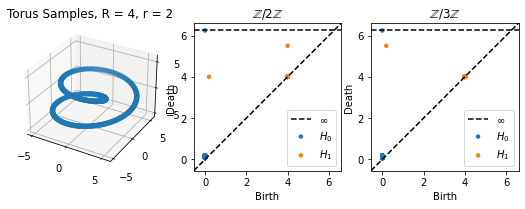

In [6]:
NPoints = 400
R = 4
r = 2
theta = np.linspace(0, 2*np.pi, NPoints+1)[0:NPoints]
phi = theta*2
X = np.zeros((NPoints, 3))
X[:, 0] = (R + r*np.cos(theta))*np.cos(phi)
X[:, 1] = (R + r*np.cos(theta))*np.sin(phi)
X[:, 2] = r*np.sin(theta)
xr = [np.min(X.flatten()), np.max(X.flatten())]

#Now compute persistence diagrams with Z/2 coefficients
dgms2 = ripser(X, maxdim=1, coeff=2)['dgms']
dgms3 = ripser(X, maxdim=1, coeff=3)['dgms']

plt.figure(figsize=(9, 3))
ax = plt.subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
ax.set_xlim(xr)
ax.set_ylim(xr)
ax.set_zlim(xr)
plt.title("Torus Samples, R = %g, r = %g"%(R, r))
plt.subplot(132)
plot_diagrams(dgms2)
plt.title("$\mathbb{Z} / 2 \mathbb{Z}$")
plt.subplot(133)
plot_diagrams(dgms3)
plt.title("$\mathbb{Z} / 3 \mathbb{Z}$")
plt.show()

In [ ]:
An estimator of the intrinsic metric